In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

from xgboost import XGBClassifier
import shap

In [4]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 5.7 MB/s eta 0:00:00


In [5]:
from fairlearn.metrics import (
    MetricFrame, selection_rate, demographic_parity_difference,
    equalized_odds_difference
)

In [6]:
df = pd.read_csv("/content/df_feature_engineered.csv")

In [7]:
df.head()

,partner_id,role,gender,age_group,city_tier,earnings_avg,on_time_rate,cancel_rate,customer_rating,complaints,...,engagement_ratio,weekly_trip_ratio,reliability_index,complaint_rate,accident_rate,txn_freq_per_day,wallet_txn_flag,vehicle_utilization,earnings_vs_city_avg,rating_vs_age_avg
0,1,driver,M,<=25,2,638.443420,0.964244,0.135795,4.837981,0,...,0.513514,2.600000,0.833304,0.000000,0.0,8.001422,1,9.744333,0.913992,1.023845
1,2,merchant,M,<=25,2,444.440684,0.931376,0.061321,4.778687,0,...,1.333333,2.120000,0.874263,0.000000,0.0,4.188749,1,8.175693,0.636259,1.011297
2,3,merchant,M,26-35,1,659.666189,0.960345,0.045608,4.418110,1,...,0.451613,1.206897,0.916545,0.027778,0.0,4.623777,1,4.948950,0.942219,0.934736
3,4,driver,F,<=25,3,503.720971,0.850885,0.053521,4.782128,0,...,0.529412,3.052632,0.805345,0.000000,0.0,14.130121,1,11.814075,0.721940,1.012025
4,5,driver,M,50+,3,637.742060,0.970612,0.150525,4.905054,0,...,0.678571,2.850000,0.824510,0.000000,0.0,0.000000,0,12.631052,0.914021,1.038896


In [8]:
categorical_features = ["role", "gender", "age_group", "city_tier",
                        "vehicle_age_bin", "wallet_txn_bin"]

In [9]:
numeric_features = [col for col in df.columns
                    if col not in categorical_features + ["partner_id", "good_repayment"]]

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ]
)

In [11]:
X = df.drop(columns=["partner_id", "good_repayment"])
y = df["good_repayment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
log_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=500, class_weight="balanced", random_state=42))
])

log_clf.fit(X_train, y_train)
y_pred_log = log_clf.predict(X_test)
y_prob_log = log_clf.predict_proba(X_test)[:, 1]

auc_log = roc_auc_score(y_test, y_prob_log)
print("Logistic AUC:", auc_log)


Logistic AUC: 0.6312862892077048


In [13]:
xgb_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        scale_pos_weight=1, random_state=42, eval_metric="logloss"
    ))
])

xgb_clf.fit(X_train, y_train)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print("XGBoost AUC:", auc_xgb)


XGBoost AUC: 0.5770483241682284


In [14]:
# sensitive attribute
sensitive_test = X_test["city_tier"]

metric_frame = MetricFrame(
    metrics={"AUC": roc_auc_score, "Selection Rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred_log,
    sensitive_features=sensitive_test
)

print("Fairness by City Tier (Logistic):")
print(metric_frame.by_group)

print("Demographic Parity Difference:", demographic_parity_difference(y_test, y_pred_log, sensitive_features=sensitive_test))
print("Equalized Odds Difference:", equalized_odds_difference(y_test, y_pred_log, sensitive_features=sensitive_test))


Fairness by City Tier (Logistic):
                AUC  Selection Rate
city_tier                          
1          0.646283        0.642450
2          0.534201        0.613126
3          0.590909        0.532915
Demographic Parity Difference: 0.10953478194857502
Equalized Odds Difference: 0.18475073313782986


## Feature Importance

In [20]:
import pandas as pd
import numpy as np

# Assuming you already fit Logistic Regression with sklearn pipeline
model = log_clf.named_steps["classifier"]   # logistic regression model
feature_names = log_clf.named_steps["preprocessor"].get_feature_names_out()

# Get coefficients
coef = model.coef_[0]

# Put into DataFrame
lr_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": np.abs(coef),
    "direction": coef
}).sort_values(by="importance", ascending=False)

print(lr_importance.head(15))


                     feature  importance
38          txn_freq_per_day    0.360633
30        earnings_stability    0.267944
26            cashless_ratio    0.254953
18  wallet_txn_bin_Very High    0.233991
1              role_merchant    0.227608
11       vehicle_age_bin_mid    0.210797
16        wallet_txn_bin_Low   -0.197297
31         tenure_x_earnings    0.176600
27          past_due_history   -0.173719
0                role_driver   -0.157606


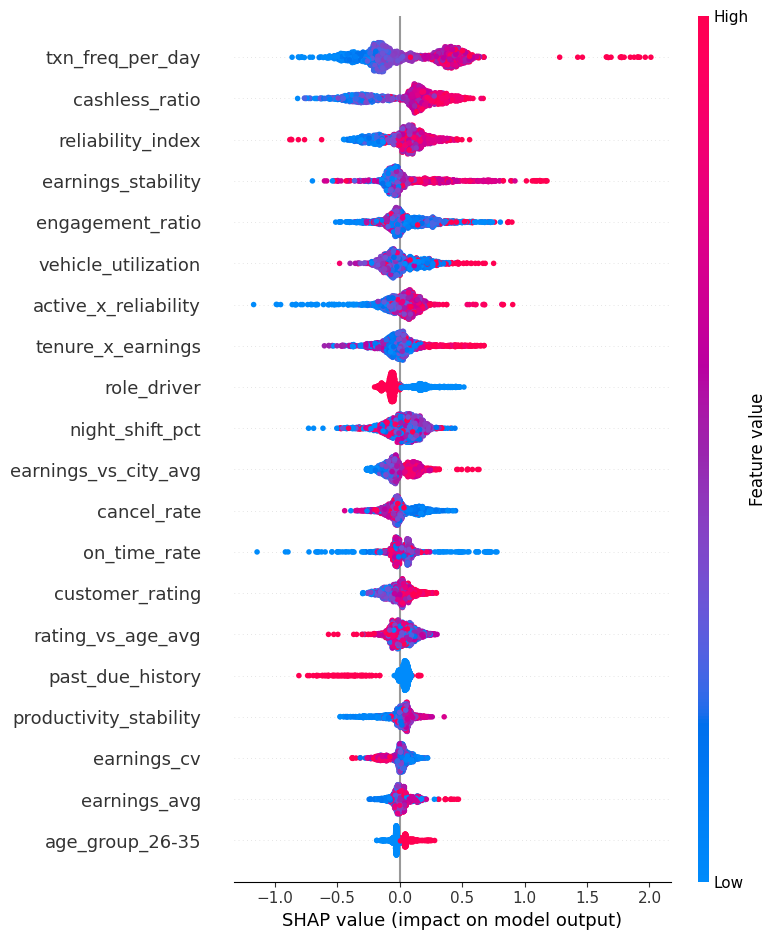

In [16]:
# Extract processed training data
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# SHAP
explainer = shap.TreeExplainer(xgb_clf.named_steps["classifier"])
shap_values = explainer.shap_values(X_test_proc)

shap.summary_plot(shap_values, X_test_proc, feature_names=all_features)


In [17]:
shap_values

array([[ 0.21243778,  0.        , -0.00695003, ...,  0.2724957 ,
        -0.04025817,  0.05874467],
       [ 0.18145254,  0.        ,  0.00594704, ...,  0.2942314 ,
        -0.03985379,  0.03566344],
       [-0.15014139,  0.        ,  0.00386494, ...,  0.09168153,
        -0.12442684, -0.02656998],
       ...,
       [-0.04598133,  0.        , -0.02572329, ..., -0.02648406,
         0.09809972,  0.08838167],
       [ 0.12269992,  0.        ,  0.00548964, ..., -0.07390174,
        -0.0605516 ,  0.01094588],
       [-0.02127378,  0.        ,  0.00224563, ...,  0.23870328,
        -0.10625863,  0.10393275]], dtype=float32)

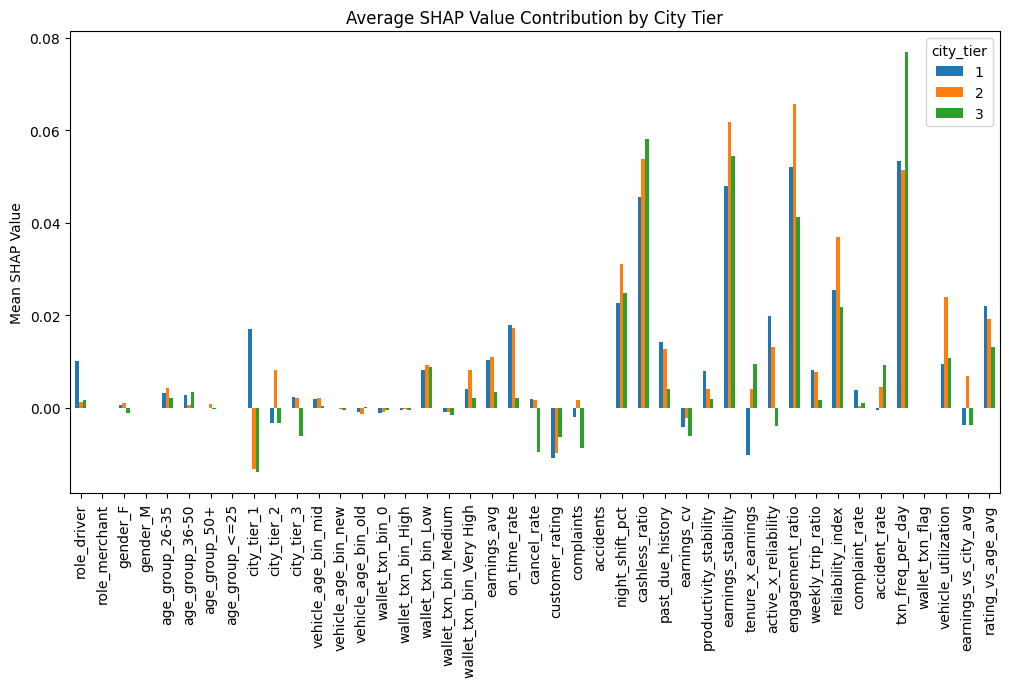

In [18]:
import matplotlib.pyplot as plt

# 1. Get average SHAP value by sensitive group (say city_tier)
shap_mean_by_group = pd.DataFrame(shap_values, columns=all_features)
shap_mean_by_group["city_tier"] = X_test["city_tier"].values
group_shap = shap_mean_by_group.groupby("city_tier").mean().T

# 2. Plot differences across groups
group_shap.plot(kind="bar", figsize=(12,6))
plt.title("Average SHAP Value Contribution by City Tier")
plt.ylabel("Mean SHAP Value")
plt.show()
